<a href="https://www.kaggle.com/code/hunhnguynphc/community-detection-for-nips-dataset?scriptVersionId=156406894" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
!pip install timeout-decorator

  Preparing metadata (setup.py) ... - done
  Created wheel for timeout-decorator: filename=timeout_decorator-0.5.0-py3-none-any.whl size=5006 sha256=b4f2c7832f0b4b62919beac1b76d0c9d932ac9710a2a8679527fc96aa92dcc0d
  Stored in directory: /root/.cache/pip/wheels/68/2f/bc/76f1192d474666d41ae6f09813fccbd00fe3f07e8261c4cff5
Successfully built timeout-decorator


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from copy import deepcopy
from timeout_decorator import timeout
import time
import gc
import pickle

In [4]:
url = '/kaggle/input/'

papers = pd.read_csv(url + 'nips-papers/papers.csv')
authors = pd.read_csv(url + 'nips-papers/authors.csv')
paper_authors = pd.read_csv(url + 'nips-papers/paper_authors.csv')

# Data Preprocessing

In [5]:
papers.head(10)

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."
5,1002,1994,Using a neural net to instantiate a deformable...,NaN,1002-using-a-neural-net-to-instantiate-a-defor...,Abstract Missing,U sing a neural net to instantiate a\ndeformab...
6,1003,1994,Plasticity-Mediated Competitive Learning,NaN,1003-plasticity-mediated-competitive-learning.pdf,Abstract Missing,Plasticity-Mediated Competitive Learning\n\nTe...
7,1004,1994,ICEG Morphology Classification using an Analog...,NaN,1004-iceg-morphology-classification-using-an-a...,Abstract Missing,ICEG Morphology Classification using an\nAnalo...
8,1005,1994,Real-Time Control of a Tokamak Plasma Using Ne...,NaN,1005-real-time-control-of-a-tokamak-plasma-usi...,Abstract Missing,Real-Time Control of a Tokamak Plasma\nUsing N...
9,1006,1994,Pulsestream Synapses with Non-Volatile Analogu...,NaN,1006-pulsestream-synapses-with-non-volatile-an...,Abstract Missing,Real-Time Control of a Tokamak Plasma\nUsing N...


In [6]:
authors.head(10)

,id,name
0,1,Hisashi Suzuki
1,10,David Brady
2,100,Santosh S. Venkatesh
3,1000,Charles Fefferman
4,10000,Artur Speiser
5,10001,Fabio Cecchi
6,10002,Nidhi Hegde
7,10003,Ethan Elenberg
8,10004,Moran Feldman
9,10005,Will Dabney


In [7]:
authors.columns = ['author_id', 'name']

In [8]:
paper_authors.head(10)

,id,paper_id,author_id
0,1,63,94
1,2,80,124
2,3,80,125
3,4,80,126
4,5,80,127
5,6,9,13
6,7,20,33
7,8,20,34
8,9,20,35
9,10,66,99


In [9]:
paper_authors = pd.merge(paper_authors, authors, on ='author_id')

In [10]:
paper_authors.head(10)

,id,paper_id,author_id,name
0,1,63,94,Yaser S. Abu-Mostafa
1,347,157,94,Yaser S. Abu-Mostafa
2,555,206,94,Yaser S. Abu-Mostafa
3,1314,616,94,Yaser S. Abu-Mostafa
4,2066,930,94,Yaser S. Abu-Mostafa
5,2815,1270,94,Yaser S. Abu-Mostafa
6,3253,1435,94,Yaser S. Abu-Mostafa
7,3979,1675,94,Yaser S. Abu-Mostafa
8,2,80,124,Joshua Alspector
9,384,159,124,Joshua Alspector


In [11]:
paper_authors.drop(['id'], axis = 1, inplace = True)

paper_authors.columns = ['id', 'authors_id', 'authors']

paper_authors = paper_authors.groupby('id')[['authors_id', 'authors']].agg(list).reset_index()

In [12]:
paper_authors.head(10)

,id,authors_id,authors
0,1,"[1, 2]","[Hisashi Suzuki, Suguru Arimoto]"
1,2,[3],[Philip A. Chou]
2,3,"[252, 7094]","[Eric B. Baum, Frank Wilczek]"
3,4,"[4, 5]","[John C. Platt, Alan H. Barr]"
4,5,[6],[Ralph Linsker]
5,6,"[7, 8]","[Gene A. Tagliarini, Edward W. Page]"
6,7,"[9, 10, 11]","[Ken Hsu, David Brady, Demetri Psaltis]"
7,8,[12],[Frank H. Eeckman]
8,9,[13],[Amir F. Atiya]
9,10,[14],[Christopher L. Scofield]


In [13]:
papers = pd.merge(papers, paper_authors, on='id')

papers.head(10)

,id,year,title,event_type,pdf_name,abstract,paper_text,authors_id,authors
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,"[1, 2]","[Hisashi Suzuki, Suguru Arimoto]"
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,[14],[Christopher L. Scofield]
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,"[54, 155]","[Terrence J. Sejnowski, Patric K. Stanton]"
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...,"[902, 1229]","[Gerhard Paass, J?rg Kindermann]"
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a...","[371, 1230]","[Anders Krogh, Jesper Vedelsby]"
5,1002,1994,Using a neural net to instantiate a deformable...,NaN,1002-using-a-neural-net-to-instantiate-a-defor...,Abstract Missing,U sing a neural net to instantiate a\ndeformab...,"[121, 755, 756]","[Geoffrey E. Hinton, Christopher K. I. William..."
6,1003,1994,Plasticity-Mediated Competitive Learning,NaN,1003-plasticity-mediated-competitive-learning.pdf,Abstract Missing,Plasticity-Mediated Competitive Learning\n\nTe...,"[54, 686]","[Terrence J. Sejnowski, Nicol N. Schraudolph]"
7,1004,1994,ICEG Morphology Classification using an Analog...,NaN,1004-iceg-morphology-classification-using-an-a...,Abstract Missing,ICEG Morphology Classification using an\nAnalo...,"[823, 819, 1008, 820]","[Barry Flower, Marwan A. Jabri, Richard Coggin..."
8,1005,1994,Real-Time Control of a Tokamak Plasma Using Ne...,NaN,1005-real-time-control-of-a-tokamak-plasma-usi...,Abstract Missing,Real-Time Control of a Tokamak Plasma\nUsing N...,"[7028, 7029, 7030, 7032, 7033, 7035]","[Chris M. Bishop, Paul S. Haynes, Mike E U Smi..."
9,1006,1994,Pulsestream Synapses with Non-Volatile Analogu...,NaN,1006-pulsestream-synapses-with-non-volatile-an...,Abstract Missing,Real-Time Control of a Tokamak Plasma\nUsing N...,"[47, 898, 1231, 1232, 1233]","[Alan F. Murray, Stephen Churcher, A. J. Holme..."


In [14]:
papers.shape

(7238, 9)

# Context processing

In [15]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from transformers import BertTokenizer, BertModel
import torch

model_name = 'bert-large-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)

ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

In [16]:
def text_preprocessing(caption):
    caption = caption.lower()
    caption = re.sub(r'[^a-zA-Z0-9 ]', '', caption)
    
    caption = ps.stem(caption)
    parts = caption.split(' ')
    
    # Remove stop words
    parts = [part for part in parts if part not in stop_words]
    
    return ' '.join(parts)

In [17]:
papers['processed_title'] = papers['title'].apply(lambda x: text_preprocessing(x))

In [18]:
papers.head(10)

,id,year,title,event_type,pdf_name,abstract,paper_text,authors_id,authors,processed_title
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...,"[1, 2]","[Hisashi Suzuki, Suguru Arimoto]",selforganization associative database appl
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...,[14],[Christopher L. Scofield],mean field theory layer iv visual cortex appli...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...,"[54, 155]","[Terrence J. Sejnowski, Patric K. Stanton]",storing covariance associative longterm potent...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...,"[902, 1229]","[Gerhard Paass, J?rg Kindermann]",bayesian query construction neural network model
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a...","[371, 1230]","[Anders Krogh, Jesper Vedelsby]",neural network ensembles cross validation acti...
5,1002,1994,Using a neural net to instantiate a deformable...,NaN,1002-using-a-neural-net-to-instantiate-a-defor...,Abstract Missing,U sing a neural net to instantiate a\ndeformab...,"[121, 755, 756]","[Geoffrey E. Hinton, Christopher K. I. William...",using neural net instantiate deformable model
6,1003,1994,Plasticity-Mediated Competitive Learning,NaN,1003-plasticity-mediated-competitive-learning.pdf,Abstract Missing,Plasticity-Mediated Competitive Learning\n\nTe...,"[54, 686]","[Terrence J. Sejnowski, Nicol N. Schraudolph]",plasticitymediated competitive learn
7,1004,1994,ICEG Morphology Classification using an Analog...,NaN,1004-iceg-morphology-classification-using-an-a...,Abstract Missing,ICEG Morphology Classification using an\nAnalo...,"[823, 819, 1008, 820]","[Barry Flower, Marwan A. Jabri, Richard Coggin...",iceg morphology classification using analogue ...
8,1005,1994,Real-Time Control of a Tokamak Plasma Using Ne...,NaN,1005-real-time-control-of-a-tokamak-plasma-usi...,Abstract Missing,Real-Time Control of a Tokamak Plasma\nUsing N...,"[7028, 7029, 7030, 7032, 7033, 7035]","[Chris M. Bishop, Paul S. Haynes, Mike E U Smi...",realtime control tokamak plasma using neural n...
9,1006,1994,Pulsestream Synapses with Non-Volatile Analogu...,NaN,1006-pulsestream-synapses-with-non-volatile-an...,Abstract Missing,Real-Time Control of a Tokamak Plasma\nUsing N...,"[47, 898, 1231, 1232, 1233]","[Alan F. Murray, Stephen Churcher, A. J. Holme...",pulsestream synapses nonvolatile analogue amor...


In [19]:
id_list = list(papers['id'])
title_list = list(papers['title'])

In [20]:
title_word = {}
author_list = {}
for i in range(len(papers)):
    data = papers.iloc[i,:]['processed_title']
    paper_id = papers.iloc[i,:]['id']
    title_word[paper_id] = set(tokenizer(ps.stem(data))['input_ids'])
    title_word[paper_id].remove(101)
    title_word[paper_id].remove(102)
    
    author_list[paper_id] = papers.iloc[i,:]['authors_id']

In [21]:
inverse_index_title = {}

for key, value in list(title_word.items()):
    for i in value:
        if i not in list(inverse_index_title.keys()):
            inverse_index_title[i] = []
        inverse_index_title[i].append(key)

In [22]:
inverse_index_author = {}

for key, value in list(author_list.items()):
    for i in value:
        if i not in list(inverse_index_author.keys()):
            inverse_index_author[i] = []
        inverse_index_author[i].append(key)

# Build the graph of papers and apply Louvain algorithm

In [23]:
import networkx as nx
import community
import nltk
from sklearn.metrics.pairwise import cosine_similarity

In [24]:
def get_weight_matrix():
    author_weight_matrix = {}
    subject_weight_matrix = {}
    start_time = time.time()
   
    for i in inverse_index_author.values():
        for index_1, j in enumerate(i):
            for index_2, k in enumerate(i):
                if index_2 <= index_1: 
                    continue
                min_value = min(j, k)
                max_value = max(j, k)
                value = author_weight_matrix.get((min_value, max_value), -1)
                if value == -1:
                    author_weight_matrix[(min_value, max_value)] = 0
                else:
                    author_weight_matrix[(min_value, max_value)] += 1
                    
    values = list(author_weight_matrix.values())

    min_value = min(values)
    max_value = max(values)

    for key in author_weight_matrix:
        original_value = author_weight_matrix[key]
        scaled_value = (original_value - min_value) / (max_value - min_value)
        author_weight_matrix[key] = scaled_value

    for i in inverse_index_title.values():
        for index_1, j in enumerate(i):
            for index_2, k in enumerate(i):
                if index_2 <= index_1: 
                    continue
                min_value = min(j, k)
                max_value = max(j, k)
                value = subject_weight_matrix.get((min_value, max_value), -1)
                if value == -1:
                    subject_weight_matrix[(min_value, max_value)] = 0
                else:
                    subject_weight_matrix[(min_value, max_value)] += 1
                    
    for i, j in subject_weight_matrix.keys():
        subject_weight_matrix[(i, j)] = subject_weight_matrix[(i, j)]/(len(title_word[i])+len(title_word[j]) - subject_weight_matrix[(i, j)])
        
    values = list(subject_weight_matrix.values())

    min_value = min(values)
    max_value = max(values)

    for key in subject_weight_matrix:
        original_value = subject_weight_matrix[key]
        scaled_value = (original_value - min_value) / (max_value - min_value)
        subject_weight_matrix[key] = scaled_value
               
    end_time = time.time()
    print(f"Processing time: {end_time - start_time}")
    
    return author_weight_matrix, subject_weight_matrix

In [25]:
try:
    with open(url + 'nips-paper-dataset-information/author_weight.pkl', 'rb') as file:
        author_weight_matrix = pickle.load(file)
        
    with open(url + 'nips-paper-dataset-information/subject_weight.pkl', 'rb') as file:
        subject_weight_matrix = pickle.load(file)
except:
    author_weight_matrix, subject_weight_matrix = get_weight_matrix()
        
    with open('author_weight.pkl', 'wb') as file:
        pickle.dump(author_weight_matrix, file)
        
    with open('subject_weight.pkl', 'wb') as file:
        pickle.dump(subject_weight_matrix, file)

In [26]:
def get_graph(alpha = 0.4, beta = 0.6):
    try:
        with open(url + 'nips-paper-dataset-information/graph.pkl', 'rb') as file:
            graph = pickle.load(file)
    except:
        start_time = time.time()

        graph = {i: {} for i in id_list}

        for i, j in author_weight_matrix.keys():
            if author_weight_matrix[(i, j)] > 0:
                graph[i][j] = {'weight': alpha * author_weight_matrix[(i, j)]}
                graph[j][i] = {'weight': alpha * author_weight_matrix[(i, j)]}

        for i, j in subject_weight_matrix.keys():
            if subject_weight_matrix[(i, j)] > 0:
                if graph[i].get(j, -1) == -1:
                    graph[i][j] = {'weight': beta * subject_weight_matrix[(i, j)]}
                    graph[j][i] = {'weight': beta * subject_weight_matrix[(i, j)]}
                else:
                    graph[i][j]['weight'] += beta * subject_weight_matrix[(i, j)]
                    graph[j][i]['weight'] += beta * subject_weight_matrix[(i, j)]

        end_time = time.time()

        print(f"Graph building time: {end_time - start_time}")

        with open('graph.pkl', 'wb') as file:
            pickle.dump(graph, file)
    
    return nx.Graph(graph)

In [27]:
graph = get_graph()

In [28]:
try:
    with open(url + 'nips-paper-dataset-information/partition_list.pkl', 'rb') as file:
        partition_list = pickle.load(file)
    with open(url + 'nips-paper-dataset-information/partition_mapping.pkl', 'rb') as file:
        partition_mapping = pickle.load(file)
except:
    start_time = time.time()
    partition = community.best_partition(graph)
    end_time = time.time()
    print(f"Algorithm running time: {end_time - start_time}")

    nx.set_node_attributes(graph, partition, 'community')

    partition_list = dict()
    partition_mapping = dict()

    for node, community_id in partition.items():
        if partition_list.get(community_id, -1) == -1:
            partition_list[community_id] = [node]
        else:
            partition_list[community_id].append(node)
        partition_mapping[node] = community_id 
        print(f"Node {node}: Community {community_id}")

    with open('partition_list.pkl', 'wb') as file:
        pickle.dump(partition_list, file)

    with open('partition_mapping.pkl', 'wb') as file:
        pickle.dump(partition_mapping, file)

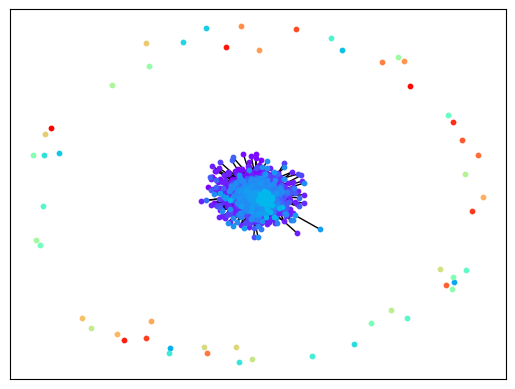

In [29]:
pos = nx.spring_layout(graph)

communities = list(partition_list.keys())
colors = plt.cm.rainbow(np.linspace(0, 1, len(communities)))

for i, community in enumerate(communities):
    nodes_in_community = partition_list[community]
    nx.draw_networkx_nodes(graph, pos, nodelist=nodes_in_community, node_color=colors[i], node_size=10, label=f'Community {i + 1}')

nx.draw_networkx_edges(graph, pos)

plt.show()

In [30]:
@timeout(20)
def main():
    input_id = int(input("Enter the paper's id: "))

    if input_id not in id_list:
        print("\nNot have paper with this id.")
        return
    
    paper_index = id_list.index(input_id)
    print(f"\nYou have chosen paper: {title_list[paper_index]}")
    print("\nHere are the papers recommended as similar to this paper:\n")
    
    partition_index = partition_mapping[input_id]
    
    neighbor_list = deepcopy(partition_list[partition_index])
    neighbor_list.remove(input_id)
    
    weight_list = [graph.get_edge_data(input_id, i)['weight'] if graph.has_edge(input_id, i) else 0 for i in neighbor_list]
    
    top_indices = sorted(range(len(weight_list)), key=lambda k: weight_list[k], reverse=True)[:min(5, len(weight_list))]
    
    for i, index in enumerate(top_indices):
        neighbor_id = neighbor_list[index]
        print(f"{i+1}. {title_list[id_list.index(neighbor_id)]}\n")

In [31]:
if __name__ == "__main__":
    try:
        main()
    except:
        print("Function timed out.")

Function timed out.
